## Notebook Overview: Socioeconomic Clustering of U.S. Counties

This notebook performs clustering analysis on U.S. counties using latent factors derived from American Community Survey (ACS) data and geographic classification variables. The goal is to identify distinct county profiles that capture demographic, economic, and geographic variation across the country.

Key steps include:

- Standardizing and filtering ACS-derived variables for stability and relevance
- Conducting factor analysis with varimax rotation to extract interpretable latent dimensions
- Selecting the number of clusters using inertia and silhouette diagnostics
- Performing K-Means clustering using both factor scores and rural-urban classification
- Assigning descriptive labels to clusters based on dominant patterns
- Merging cluster results back to the full dataset and visualizing group distributions spatially

The final output supports regional and comparative analysis of county-level characteristics across the United States.


In [27]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from factor_analyzer import FactorAnalyzer, Rotator
from sklearn.decomposition import FactorAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Base data directory
DATA_DIR = Path("data")

### Prepare Demographic Data for Clustering

This block loads the enriched county-level dataset and filters for non-weather demographic and socioeconomic variables. It performs the following transformations:

- Converts raw population subgroup counts to population percentages  
- Normalizes percent-based features to a 0–1 scale  
- Removes static or redundant ACS columns to focus on dynamic trends (e.g., YoY changes, rolling averages)  
- Fills missing values using groupwise and global mean imputation

The result is a cleaned DataFrame ready for dimensionality reduction and clustering.


In [28]:
county_dtypes = {
    "geo_id": str,
    "state": str,
    "county_name": str,
    "urban_classification": str
}

county_df = pd.read_csv(DATA_DIR / "county_weather_acs_training.csv", dtype=county_dtypes)

# Identify non-weather and raw change columns
non_weather_cols = [col for col in county_df.columns if not any(
    substr in col for substr in [
        "avg_temp", "heat_days", "max_temp", "total_precip",
        "num_events", "total_deaths", "total_injuries",
        "total_property_damage", "total_crop_damage", "_change"
    ])
]

county_df = county_df[non_weather_cols].copy()

pop_columns = [
    "white_pop",
    "black_pop",
    "hispanic_pop",
    "asian_pop",
    "bachelors_degree_or_higher_25_64",
    "less_than_high_school_graduate",
    "some_college_and_associates_degree",
    "different_house_year_ago_same_city",
    "different_house_year_ago_different_city"
]

# Adjust population columns to percentage of total population and rename
for col in pop_columns:
    county_df[col] = county_df[col] / county_df["total_pop"]
    new_col_name = col + "_pct"
    county_df.rename(columns={col: new_col_name}, inplace=True)

county_df = county_df.copy()

# Ensure consistent percentage scale``
for i in county_df.columns:
    if i.endswith("_pct_yoy") or i.__contains__("percent") and county_df[i].max() > 1:
        county_df[i] = county_df[i] / 100 

# Remove unnecessary columns and drop static ACS columns to focus on % YoY changes and 3yr rolling averages
county_df.drop(columns=[
    "reporting_stations", \
    "state_fips", 
    "county_geometry",
    "county_fips", 
    "County_Name",
    "Population_2020", 
    "has_acs", 
    "median_income", 
    "total_pop", 
    "poverty", 
    "gini_index",
    "median_rent",
    "total_pop_roll3",
    "poverty_roll3",
    "percent_income_spent_on_rent",
    "rent_over_50_percent"], inplace=True)

# Handle NaN values by filling them with the mean of the geo_id group
for col in county_df.columns:
    if county_df[col].isnull().sum() > 0:
        # Fill within geo_id group
        county_df[col] = county_df.groupby("geo_id")[col].transform(
            lambda grp: grp.fillna(grp.mean())
        )

        # Fill remaining NaNs with column-wide mean (avoiding chained assignment)
        county_df[col] = county_df[col].fillna(county_df[col].mean())

# Review the data types and null values
print(county_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   geo_id                                       16860 non-null  object 
 1   county_name                                  16860 non-null  object 
 2   year                                         16860 non-null  int64  
 3   median_age                                   16860 non-null  float64
 4   white_pop_pct                                16860 non-null  float64
 5   black_pop_pct                                16860 non-null  float64
 6   hispanic_pop_pct                             16860 non-null  float64
 7   asian_pop_pct                                16860 non-null  float64
 8   bachelors_degree_or_higher_25_64_pct         16860 non-null  float64
 9   less_than_high_school_graduate_pct           16860 non-null  float64
 10

### Check for Multicollinearity via Correlation Matrix

This block computes a Pearson correlation matrix using only numeric features and visualizes it as a heatmap. The goal is to identify strong linear relationships (|r| > 0.8) that may indicate multicollinearity or feature redundancy. The heatmap uses a diverging color scale centered at zero to emphasize both positive and negative correlations.


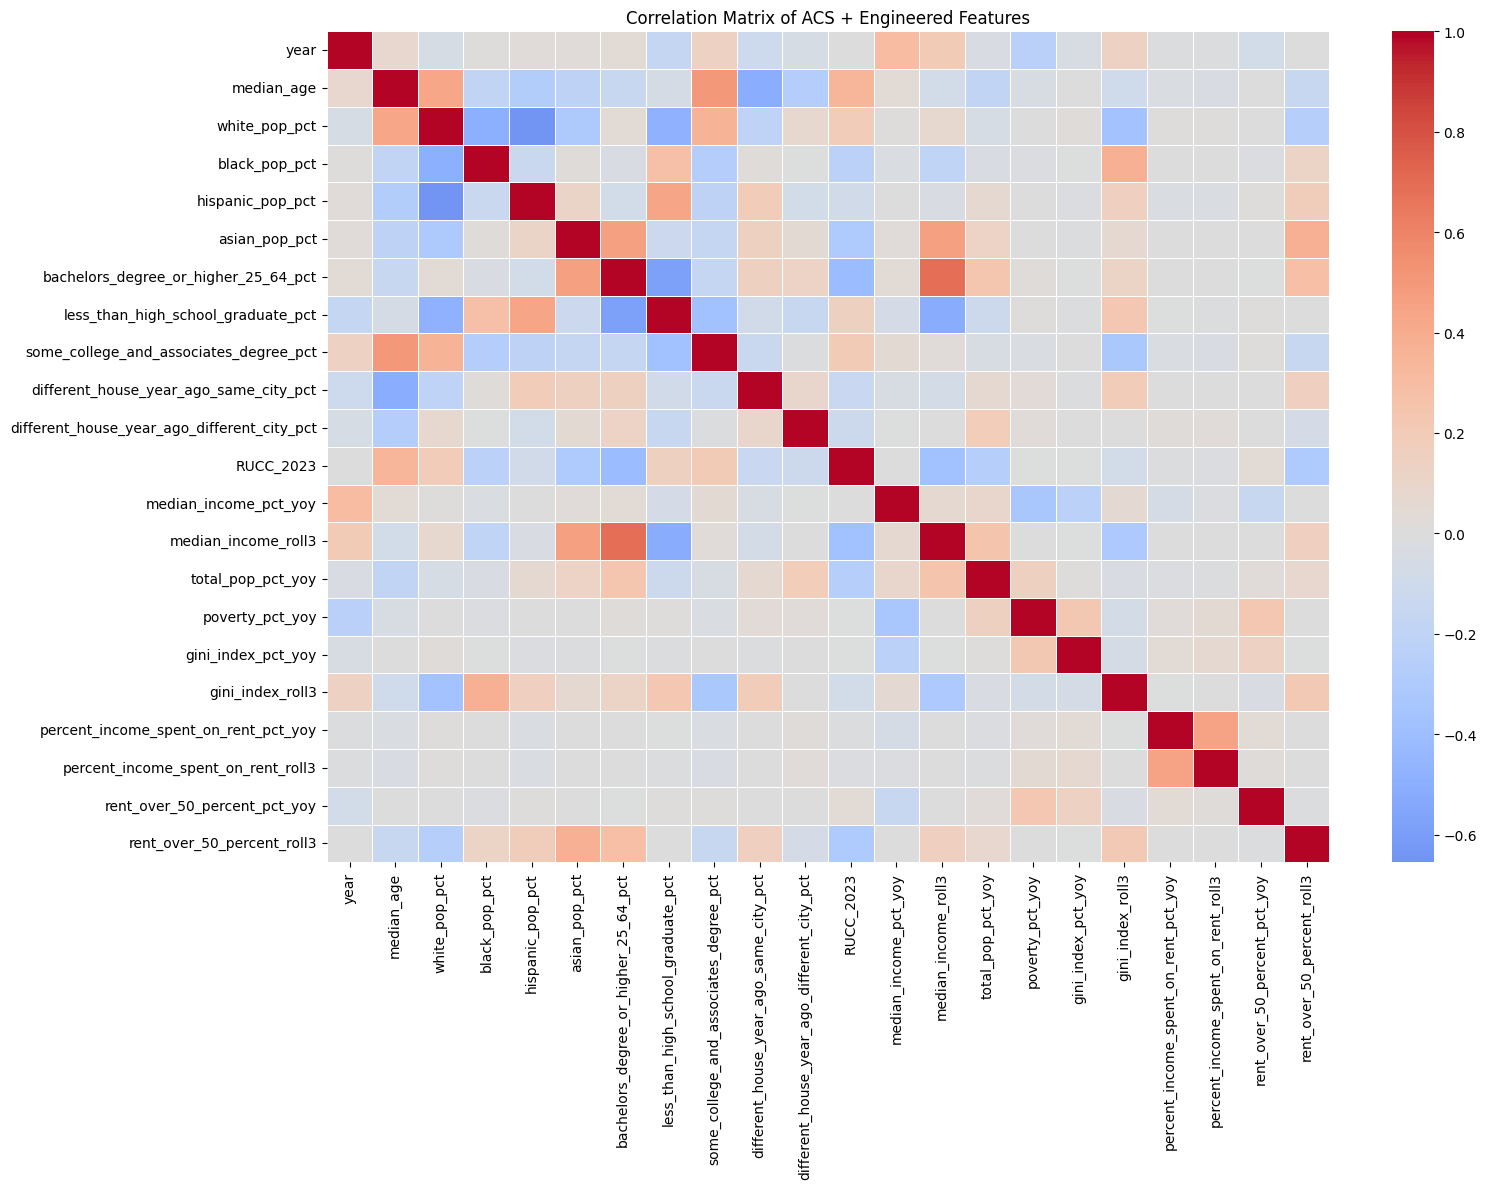

In [29]:
# Select only numeric columns (exclude object types)
numeric_cols = county_df.select_dtypes(include=["float64", "int64"]).columns

# Compute correlation matrix
corr = county_df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix of ACS + Engineered Features")
plt.tight_layout()
plt.show()

### Assess Feature Multicollinearity with VIF

This block computes Variance Inflation Factor (VIF) scores for all numeric features to assess multicollinearity. A constant term is added to the dataset to support VIF calculation using `statsmodels`. Features with high VIF values (typically > 5 or 10) may indicate redundancy and can be candidates for removal or dimensionality reduction.


In [30]:
# Select only numeric columns for VIF calculation (exclude identifiers and categorical fields)
acs_numeric = county_df.select_dtypes(include=["float64", "int64"]).drop(columns=["year", "RUCC_2023"], errors="ignore")

# Add a constant for statsmodels VIF calculation
X = add_constant(acs_numeric)

# Compute VIF for each feature
vif_data = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Drop the constant row for readability
vif_data = vif_data[vif_data["feature"] != "const"]

# Sort by highest VIF
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print(vif_data)


                                        feature       VIF
2                                 white_pop_pct  6.509905
6          bachelors_degree_or_higher_25_64_pct  4.675683
4                              hispanic_pop_pct  4.673465
7            less_than_high_school_graduate_pct  4.171775
12                          median_income_roll3  3.511562
3                                 black_pop_pct  3.451731
1                                    median_age  2.752505
8        some_college_and_associates_degree_pct  2.457612
5                                 asian_pop_pct  1.997446
16                             gini_index_roll3  1.915744
9        different_house_year_ago_same_city_pct  1.710552
20                   rent_over_50_percent_roll3  1.296027
10  different_house_year_ago_different_city_pct  1.264445
18           percent_income_spent_on_rent_roll3  1.259072
17         percent_income_spent_on_rent_pct_yoy  1.255643
14                              poverty_pct_yoy  1.251304
11            

### Standardize Numeric Features

This step applies z-score standardization to all numeric features using `StandardScaler`, ensuring each has a mean of 0 and standard deviation of 1. This normalization is essential for distance-based algorithms and latent factor extraction in downstream clustering and factor analysis.


In [31]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the numeric columns
scaler.fit(acs_numeric)

# Transform the numeric columns
acs_numeric_scaled = scaler.transform(acs_numeric)

# Create a DataFrame with the scaled data
acs_numeric_scaled_df = pd.DataFrame(acs_numeric_scaled, columns=acs_numeric.columns)

# Merge the scaled data back with the original DataFrame
county_df_scaled = pd.concat([county_df.drop(columns=acs_numeric), acs_numeric_scaled_df], axis=1)

print(county_df_scaled.head())

  geo_id county_name  year State  \
0  01003     Baldwin  2010    AL   
1  01003     Baldwin  2011    AL   
2  01003     Baldwin  2012    AL   
3  01003     Baldwin  2013    AL   
4  01003     Baldwin  2014    AL   

                                         Description  RUCC_2023  \
0  Metro - Counties in metro areas of fewer than ...          3   
1  Metro - Counties in metro areas of fewer than ...          3   
2  Metro - Counties in metro areas of fewer than ...          3   
3  Metro - Counties in metro areas of fewer than ...          3   
4  Metro - Counties in metro areas of fewer than ...          3   

  urban_classification  median_age  white_pop_pct  black_pop_pct  ...  \
0                urban    0.234252       0.500681       0.044772  ...   
1                urban    0.307856       0.486216       0.047953  ...   
2                urban    0.271054       0.477252       0.033825  ...   
3                urban    0.326257       0.466838       0.048517  ...   
4              

### Select Number of Factors via Scree Plot

To determine the optimal number of latent factors to retain, we fit `FactorAnalysis` models with 1 to 20 components and plotted their log-likelihood scores. Unlike PCA, which is based on variance explained, Factor Analysis models are evaluated using log-likelihood—a measure of how well the model fits the observed data.

The **scree plot** visualizes these scores across different numbers of factors. As more factors are added, the log-likelihood increases, but typically with diminishing returns. The point where the curve begins to level off (the "elbow") helps identify a balance between model complexity and explanatory value.

This step informs the dimensionality reduction process for downstream tasks such as clustering and interpretation of latent socioeconomic patterns.


In [32]:
# # Evaluate the variance explained across 1–20 factors
# n_factors = list(range(1, 21))

# fa_models = [FactorAnalysis(n_components=n, max_iter=1000).fit(acs_numeric_scaled) for n in n_factors]

# # Extract log-likelihood values to compute approximate explained variance
# log_likelihoods = [model.score(acs_numeric_scaled) for model in fa_models]

# # Scree plot (based on log-likelihood gain, a proxy for information retained)
# plt.figure(figsize=(10, 6))
# plt.plot(n_factors, log_likelihoods, marker='o')
# plt.title("Scree Plot for Factor Analysis")
# plt.xlabel("Number of Factors")
# plt.ylabel("Log-Likelihood")
# plt.grid(True)
# plt.show()

### Extract Latent Factors and Apply Varimax Rotation

With the number of factors selected, we performed factor analysis to identify latent dimensions in the demographic dataset. Ten factors were extracted using the `FactorAnalyzer` and then rotated using **varimax**, a method that improves interpretability by making each factor load strongly on just a few features.

- **Factor Extraction**: Captures shared patterns across variables, reducing dimensionality while preserving key structure.  
- **Varimax Rotation**: Makes the results easier to interpret by helping each factor represent a more distinct and focused set of features.  
- **Loadings Inspection**: For each factor, the top 5 features by absolute loading are displayed to support labeling and interpretation of the underlying themes.

This step enables the identification of interpretable macro dimensions (e.g., income, education, housing stress) that will inform downstream clustering and analysis.


In [33]:
# Initialize and fit the factor analyzer
fa = FactorAnalyzer(n_factors=10, rotation=None)
fa.fit(acs_numeric_scaled)

# Apply varimax rotation to the factor loadings
rotator = Rotator(method="varimax")
rotated_loadings = rotator.fit_transform(fa.loadings_)

# Create a DataFrame of the rotated loadings
rotated_df = pd.DataFrame(
    rotated_loadings,
    index=acs_numeric.columns,
    columns=[f"Factor{i+1}" for i in range(rotated_loadings.shape[1])]
)

# Display top 5 features per factor based on absolute loading
for i in range(rotated_df.shape[1]):
    print(f"\nTop loadings for Factor {i+1}:")
    display(rotated_df.iloc[:, i].abs().sort_values(ascending=False).head(5))


Top loadings for Factor 1:


hispanic_pop_pct                      0.966784
white_pop_pct                         0.656993
less_than_high_school_graduate_pct    0.395084
median_age                            0.205202
rent_over_50_percent_roll3            0.132565
Name: Factor1, dtype: float64


Top loadings for Factor 2:


bachelors_degree_or_higher_25_64_pct    0.867107
median_income_roll3                     0.749327
less_than_high_school_graduate_pct      0.666465
asian_pop_pct                           0.218562
white_pop_pct                           0.162830
Name: Factor2, dtype: float64


Top loadings for Factor 3:


percent_income_spent_on_rent_roll3        0.996709
percent_income_spent_on_rent_pct_yoy      0.446560
gini_index_pct_yoy                        0.048976
some_college_and_associates_degree_pct    0.032493
total_pop_pct_yoy                         0.027527
Name: Factor3, dtype: float64


Top loadings for Factor 4:


black_pop_pct                         0.919827
white_pop_pct                         0.491480
gini_index_roll3                      0.241246
less_than_high_school_graduate_pct    0.191135
median_age                            0.172228
Name: Factor4, dtype: float64


Top loadings for Factor 5:


median_age                                     0.883545
different_house_year_ago_same_city_pct         0.565290
different_house_year_ago_different_city_pct    0.292412
less_than_high_school_graduate_pct             0.187220
some_college_and_associates_degree_pct         0.176779
Name: Factor5, dtype: float64


Top loadings for Factor 6:


poverty_pct_yoy                 0.637724
median_income_pct_yoy           0.545631
gini_index_pct_yoy              0.380272
rent_over_50_percent_pct_yoy    0.332650
gini_index_roll3                0.104053
Name: Factor6, dtype: float64


Top loadings for Factor 7:


total_pop_pct_yoy                              0.782010
different_house_year_ago_different_city_pct    0.183099
poverty_pct_yoy                                0.158957
median_income_roll3                            0.151852
median_income_pct_yoy                          0.141319
Name: Factor7, dtype: float64


Top loadings for Factor 8:


some_college_and_associates_degree_pct    0.869341
less_than_high_school_graduate_pct        0.374627
median_age                                0.338694
gini_index_roll3                          0.168960
white_pop_pct                             0.141454
Name: Factor8, dtype: float64


Top loadings for Factor 9:


gini_index_roll3                          0.649861
median_income_roll3                       0.490097
different_house_year_ago_same_city_pct    0.204028
black_pop_pct                             0.199125
bachelors_degree_or_higher_25_64_pct      0.172213
Name: Factor9, dtype: float64


Top loadings for Factor 10:


asian_pop_pct                           0.789127
rent_over_50_percent_roll3              0.441866
white_pop_pct                           0.343027
bachelors_degree_or_higher_25_64_pct    0.338303
median_income_roll3                     0.329289
Name: Factor10, dtype: float64

### Compute and Integrate Factor Scores

After extracting and interpreting the 10 latent factors, we calculated factor scores for each county to quantify how strongly they align with each dimension.

- **Factor Scoring**: Each county is projected into the latent factor space using `FactorAnalysis`, resulting in a score for each of the 10 identified traits.
- **Naming and Descriptions**: Factors are given descriptive names and plain-language summaries based on their top-loading features to aid interpretation (e.g., “rent burden and housing pressure,” “aging population and low migration”).
- **Dataset Merge**: The resulting factor scores are merged back into the cleaned dataset, providing both the original variables and a set of latent summaries for downstream clustering and interpretation.

These factor scores serve as compressed, interpretable representations of complex demographic patterns across counties.


In [34]:
# Run Factor Analysis 
fa = FactorAnalysis(n_components=10, random_state=42)
fa.fit(acs_numeric_scaled)

# Create factor names and descriptions
factor_names = [
    "hispanic_concentration_low_education",
    "high_education_income",
    "rent_burden_and_housing_pressure",
    "black_concentration_gini_inequality",
    "aging_population_low_migration",
    "poverty_and_income_volatility",
    "population_growth_inflow",
    "moderate_education_mixed_race",
    "high_income_and_inequality",
    "asian_concentration_urban_housing_stress"
]

factor_descriptions = [
    "High Hispanic population, high share with less than HS education",
    "High education and income, low educational disadvantage",
    "Extremely high % of income spent on rent, rising rental costs",
    "High Black population, moderate Gini inequality, racial-economic layering",
    "High median age, low mobility — residents tend to stay in place",
    "Recent fluctuations in poverty, income, and inequality metrics",
    "Counties experiencing population growth, especially through movers",
    "High some-college-no-degree, mixed signals on age and White population",
    "High income but persistent inequality, intra-county socioeconomic splits",
    "High Asian population, associated with high rent burden and education levels"
]

# Compute factor scores
factor_scores = fa.transform(acs_numeric_scaled)
factor_score_df = pd.DataFrame(factor_scores, columns=factor_names)

# Add descriptions as metadata
factor_metadata = pd.DataFrame({
    "factor": factor_names,
    "description": factor_descriptions
})

# Merge back into your county_df_scaled (aligns by index)
county_df_with_scores = pd.concat([county_df_scaled.reset_index(drop=True), factor_score_df], axis=1)

# Optional preview
print(county_df_with_scores.head())

  geo_id county_name  year State  \
0  01003     Baldwin  2010    AL   
1  01003     Baldwin  2011    AL   
2  01003     Baldwin  2012    AL   
3  01003     Baldwin  2013    AL   
4  01003     Baldwin  2014    AL   

                                         Description  RUCC_2023  \
0  Metro - Counties in metro areas of fewer than ...          3   
1  Metro - Counties in metro areas of fewer than ...          3   
2  Metro - Counties in metro areas of fewer than ...          3   
3  Metro - Counties in metro areas of fewer than ...          3   
4  Metro - Counties in metro areas of fewer than ...          3   

  urban_classification  median_age  white_pop_pct  black_pop_pct  ...  \
0                urban    0.234252       0.500681       0.044772  ...   
1                urban    0.307856       0.486216       0.047953  ...   
2                urban    0.271054       0.477252       0.033825  ...   
3                urban    0.326257       0.466838       0.048517  ...   
4              

c:\Users\iauge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_factor_analysis.py:299: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


### Determine Optimal Number of Clusters with Geographic Context

To segment counties based on their socioeconomic profiles and rural-urban classification, we performed K-Means clustering using the 10 rotated factor scores plus a scaled version of the `RUCC_2023` rural-urban code.

- **Feature Set**: Clustering was applied to a combined feature set capturing both latent traits and geographic settlement type.
- **Standardization**: `RUCC_2023` was z-score standardized to align with the scaled factor scores.
- **Model Evaluation**: We tested `k` values from 2 to 10 and tracked two metrics:
  - **Inertia**: Measures within-cluster variation (lower is better).
  - **Silhouette Score**: Evaluates separation between clusters (higher is better).
- **Visualization**: An elbow plot and silhouette score curve help identify the optimal `k` by balancing compactness and distinctiveness of clusters.

This setup supports data-driven selection of `k` while ensuring geographic variation is incorporated into the clustering process.


Silhouette Score for 2 clusters: 0.14343882775862177
Inertia for 2 clusters: 139483.0728899274
Silhouette Score for 3 clusters: 0.15604850706586673
Inertia for 3 clusters: 128482.71441015787
Silhouette Score for 4 clusters: 0.16412801390469084
Inertia for 4 clusters: 119205.43117265927
Silhouette Score for 5 clusters: 0.16575795505818522
Inertia for 5 clusters: 106587.32386655426
Silhouette Score for 6 clusters: 0.15902204529982694
Inertia for 6 clusters: 100523.96566697651
Silhouette Score for 7 clusters: 0.1530201619339936
Inertia for 7 clusters: 89665.51292373246
Silhouette Score for 8 clusters: 0.14268786358016436
Inertia for 8 clusters: 84067.67168237986
Silhouette Score for 9 clusters: 0.14475336284682358
Inertia for 9 clusters: 79590.45084024723
Silhouette Score for 10 clusters: 0.14159234907731436
Inertia for 10 clusters: 76325.43370948228


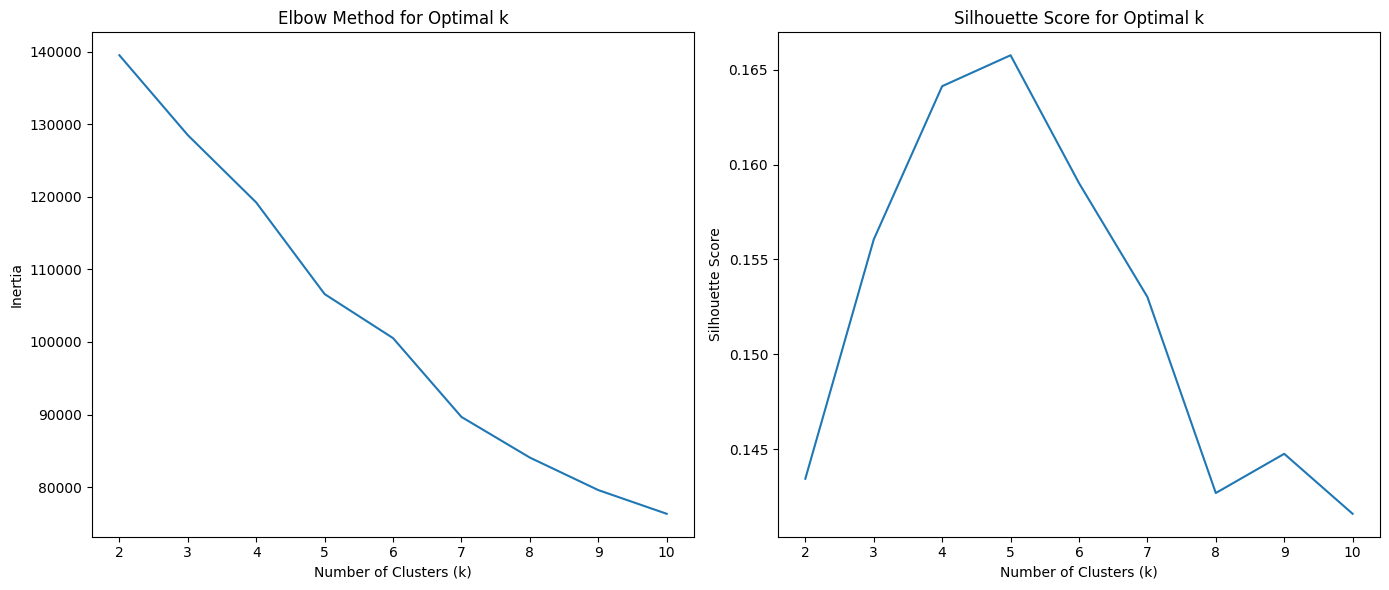

In [37]:
county_df_with_scores["RUCC_2023_scaled"] = scaler.fit_transform(
    county_df_with_scores[["RUCC_2023"]]
)
# Drop the original RUCC_2023 column
county_df_with_scores.drop(columns=["RUCC_2023"], inplace=True)

cluster_cols = factor_names + ["RUCC_2023_scaled"]
cluster_df = county_df_with_scores[cluster_cols].copy()

X = cluster_df[cluster_cols]

inertia = []
silhouette_scores = []
range_n_clusters = range(2, 11)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))
    print(f"Silhouette Score for {k} clusters: {silhouette_scores[-1]}")
    print(f"Inertia for {k} clusters: {inertia[-1]}")

# Plot the elbow method
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.lineplot(x=range_n_clusters, y=inertia, ax=axs[0])
axs[0].set_title("Elbow Method for Optimal k")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Inertia")

sns.lineplot(x=range_n_clusters, y=silhouette_scores, ax=axs[1])
axs[1].set_title("Silhouette Score for Optimal k")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()    

### Final Cluster Assignment (k = 6)

While the silhouette score and inertia plots initially pointed to **k = 5** as the optimal number of clusters, this configuration introduced an outlier cluster with only two counties, limiting its practical interpretability. To avoid overfitting and ensure more meaningful segmentation, we selected **k = 6**, which resulted in more balanced cluster sizes and clearer socioeconomic distinctions.

The final model was applied as follows:

1. **Model Training**: A `KMeans` model with `n_clusters=6` and `random_state=42` was trained using:
   - The 10 rotated factor scores derived from ACS data
   - The scaled `RUCC_2023` variable to reflect rural-urban settlement type

2. **Cluster Assignment**:
   - Predicted cluster labels were stored in a `"cluster"` column.
   - Each county was assigned to one of six clusters reflecting unique combinations of socioeconomic traits and geographic context.

3. **Cluster Size Validation**:
   - All six clusters had sufficient representation, with no singleton or degenerate groupings.
   - The added cluster (relative to `k = 5`) helped isolate a distinct profile of **high rent burden and demographic disadvantage**, previously blurred within a broader group.

This configuration forms the basis for downstream cluster labeling, visualization, and interpretation of macro patterns across U.S. counties.


In [38]:
# Assign cluster labels to the DataFrame
optimal_k = 6  # Based on elbow method and silhouette score

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto")
county_df_with_scores["cluster"] = kmeans.fit_predict(county_df_with_scores[cluster_cols])

print(county_df_with_scores["cluster"].value_counts())

cluster
1    6583
0    4499
2    2538
3    1942
5    1296
4       2
Name: count, dtype: int64


### Merge Cluster Labels and Profile Group Traits

To support interpretation and visualization, final cluster assignments and factor scores were merged back into the original dataset. A summary table was then created to describe each cluster’s average position across the 10 latent factors and rural-urban classification.

- **Cluster Merge**: The original `county_df` was joined with the factor scores and cluster labels from `county_df_with_scores` using `geo_id` and `year` as keys, resulting in a fully labeled dataset.
- **Group Profiling**: Mean values of each factor score and the `RUCC_2023` indicator were computed per cluster using `groupby("cluster")`, with results rounded for readability.

This summary highlights the distinct demographic and geographic patterns associated with each cluster and supports downstream labeling, visualization, and policy-relevant interpretation.


In [39]:
# Merge cluster labels back to the original DataFrame
labeled_county_df = county_df.merge(
    county_df_with_scores[["geo_id", "year"] + factor_names + ["cluster"]],
    on=["geo_id", "year"],
    how="left"
)

cluster_summary = labeled_county_df.groupby("cluster")[[
    "hispanic_concentration_low_education",
    "high_education_income",
    "rent_burden_and_housing_pressure",
    "black_concentration_gini_inequality",
    "aging_population_low_migration",
    "poverty_and_income_volatility",
    "population_growth_inflow",
    "moderate_education_mixed_race",
    "high_income_and_inequality",
    "asian_concentration_urban_housing_stress",
    "RUCC_2023"
]].mean().round(2)

print(cluster_summary)


         hispanic_concentration_low_education  high_education_income  \
cluster                                                                
0                                        0.08                   0.50   
1                                       -0.67                  -0.28   
2                                        0.64                   0.97   
3                                       -0.03                  -0.24   
4                                       -0.91                  -3.16   
5                                        1.95                  -1.85   

         rent_burden_and_housing_pressure  \
cluster                                     
0                                    0.32   
1                                    0.02   
2                                   -0.40   
3                                   -0.97   
4                                    4.10   
5                                    1.05   

         black_concentration_gini_inequality  aging_population

### Final Dataset Labeling and Reordering

To prepare the dataset for downstream analysis, mapping, and reporting, we assigned semantic labels to each cluster and reorganized the column layout for clarity.

- **Cluster Labeling**: A `"cluster_label"` column was created using a mapping of numeric cluster IDs to descriptive group names based on socioeconomic and geographic profiles.
- **Column Organization**: Columns were reordered into logical sections:
  - Identifiers and metadata (e.g., `geo_id`, `county_name`, `RUCC_2023`)
  - Cluster assignment and label
  - Raw ACS-derived variables (including percent and trend features)
  - Latent factor scores from the rotated factor analysis
- **Dataset Integrity**: A final `.info()` check confirmed completeness and readiness for visualization or export.

The resulting `labeled_county_df` serves as the foundation for all remaining cluster-level interpretation, geographic mapping, and comparative analysis.


In [40]:
cluster_names = {
    0: "Educated Urban Core Counties with Moderate Advantage",
    1: "Rural, Low-Education, Economically Stable Counties",
    2: "Affluent Small Metro and Regional Hub Counties",
    3: "Aging Counties with Economic Volatility",
    4: "Isolated Rural Counties with Demographic Extremes",
    5: "Counties with High Rent Burden and Structural Disadvantage"
}


labeled_county_df["cluster_label"] = labeled_county_df["cluster"].map(cluster_names)

# Reorder columns for clarity
ordered_columns = [
    # Identifiers & cluster labels
    "geo_id", "county_name", "State", "year", "RUCC_2023", "urban_classification", "Description",
    "cluster", "cluster_label",

    # Raw ACS features
    "median_age", "white_pop_pct", "black_pop_pct", "hispanic_pop_pct", "asian_pop_pct",
    "bachelors_degree_or_higher_25_64_pct", "less_than_high_school_graduate_pct",
    "some_college_and_associates_degree_pct", "different_house_year_ago_same_city_pct",
    "different_house_year_ago_different_city_pct", "median_income_pct_yoy", "median_income_roll3",
    "total_pop_pct_yoy", "poverty_pct_yoy", "gini_index_pct_yoy", "gini_index_roll3",
    "percent_income_spent_on_rent_pct_yoy", "percent_income_spent_on_rent_roll3",
    "rent_over_50_percent_pct_yoy", "rent_over_50_percent_roll3",

    # Factor scores
    "hispanic_concentration_low_education",
    "high_education_income",
    "rent_burden_and_housing_pressure",
    "black_concentration_gini_inequality",
    "aging_population_low_migration",
    "poverty_and_income_volatility",
    "population_growth_inflow",
    "moderate_education_mixed_race",
    "high_income_and_inequality",
    "asian_concentration_urban_housing_stress"
]

# Apply the reordering
labeled_county_df = labeled_county_df[ordered_columns]

labeled_county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 39 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   geo_id                                       16860 non-null  object 
 1   county_name                                  16860 non-null  object 
 2   State                                        16860 non-null  object 
 3   year                                         16860 non-null  int64  
 4   RUCC_2023                                    16860 non-null  int64  
 5   urban_classification                         16860 non-null  object 
 6   Description                                  16860 non-null  object 
 7   cluster                                      16860 non-null  int32  
 8   cluster_label                                16860 non-null  object 
 9   median_age                                   16860 non-null  float64
 10

### Geospatial Merge and Cluster Visualization

To visualize the spatial distribution of cluster assignments, we reattached county geometries and created a choropleth map of U.S. counties by cluster label.

- **Geometry Merge**: County polygons were merged back into the labeled dataset using `geo_id` and `year`, enabling spatial plotting alongside demographic attributes.
- **GeoDataFrame Construction**: The merged data was converted into a `GeoDataFrame` using `geopandas`, parsing WKT strings into valid geometries with a consistent CRS.
- **Cluster Map**: Counties were color-coded by their assigned cluster label using a custom color palette, with a legend and title for interpretability.

This map highlights clear geographic patterns in the clustering solution, reinforcing the link between latent socioeconomic traits and regional spatial structure.


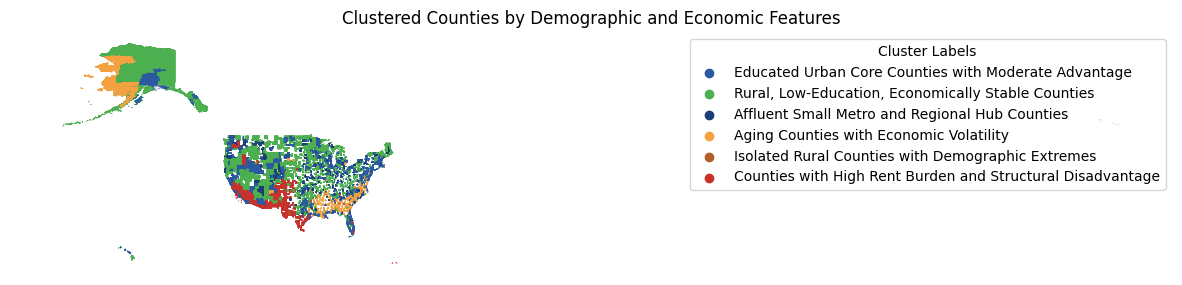

In [41]:
county_dtypes = {
    "geo_id": str,
    "state": str,
    "county_name": str,
    "urban_classification": str
}

county_df = pd.read_csv(DATA_DIR / "county_weather_acs_training.csv", dtype=county_dtypes)
    
cluster_colors = {
    "Educated Urban Core Counties with Moderate Advantage": "#2c5aa0",     # Blue – educated, urban advantage
    "Rural, Low-Education, Economically Stable Counties": "#4CAF50",       # Green – stable, neutral
    "Affluent Small Metro and Regional Hub Counties": "#1b3e75",           # Darker Blue – high SES, small metro
    "Aging Counties with Economic Volatility": "#f4a141",                  # Orange – aging, instability
    "Isolated Rural Counties with Demographic Extremes": "#b05f26",        # Brownish Orange – outliers, rural
    "Counties with High Rent Burden and Structural Disadvantage": "#c7332c" # Red – high burden, disadvantage
}

# Re-add polygon geometry
labeled_county_df = labeled_county_df.merge(
    county_df[["geo_id", "year", "county_geometry"]],
    on=["geo_id", "year"],
    how="left"
)

gdf = gpd.GeoDataFrame(
    labeled_county_df,
    geometry=gpd.GeoSeries.from_wkt(labeled_county_df["county_geometry"]),
    crs="EPSG:4326"
)   

gdf["color"] = gdf["cluster_label"].map(cluster_colors)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(color=gdf["color"], ax=ax)

for label, color in cluster_colors.items():
    ax.scatter([], [], color=color, label=label)
ax.legend(title="Cluster Labels", loc="upper right")

ax.set_title("Clustered Counties by Demographic and Economic Features")
ax.set_axis_off()
plt.show()

### Full U.S. Map with Alaska and Hawaii Insets

To provide a complete geographic view of the clustering results, we created a map that includes **all U.S. counties**, with insets for **Alaska** and **Hawaii**:

- **Main Map**: Plots the 48 contiguous states, color-coded by cluster label using the predefined color mapping.
- **Insets**:
  - **Alaska** is displayed in a lower corner inset with adjusted bounds and title positioning.
  - **Hawaii** is shown in a separate inset for visual clarity and scale preservation.
- **Legend**: A custom legend was manually added to align cluster colors with descriptive labels.

This figure ensures full national coverage and maintains visual consistency across regions, making it suitable for reports, presentations, and spatial comparisons.


C:\Users\iauge\AppData\Local\Temp\ipykernel_32864\1254729044.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


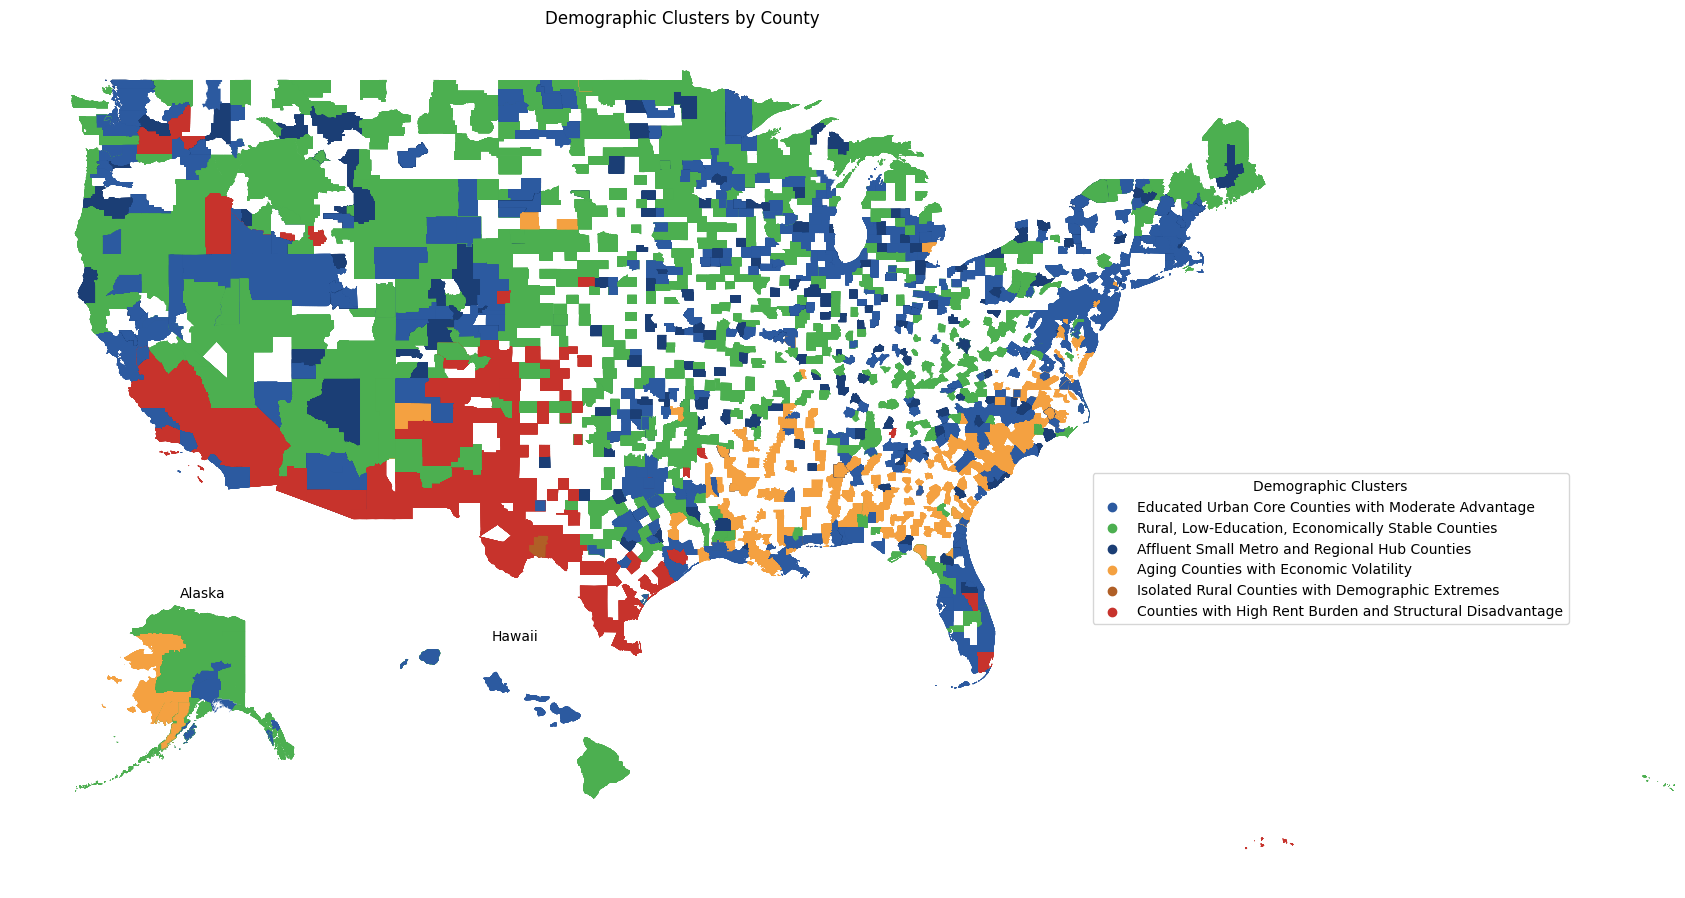

In [42]:
# Split by state
contiguous = gdf[~gdf["State"].isin(["AK", "HI"])]
alaska = gdf[gdf["State"] == "AK"]
hawaii = gdf[gdf["State"] == "HI"]

# Create main figure
fig, ax = plt.subplots(figsize=(16, 10))
contiguous.plot(color=contiguous["color"], ax=ax)
ax.set_title("Demographic Clusters by County")
ax.set_axis_off()

# --- Alaska Inset ---
ax_ak = fig.add_axes([0.05, -0.25, 1, 1])  # [x, y, width, height]
alaska.plot(color=alaska["color"], ax=ax_ak)
ax_ak.set_title("Alaska", fontsize=10, position=(0.08, 1.05))  # Adjust title position
ax_ak.set_axis_off()
ax_ak.set_xlim(*alaska.total_bounds[[0, 2]])
ax_ak.set_ylim(*alaska.total_bounds[[1, 3]])

# --- Hawaii Inset ---
ax_hi = fig.add_axes([0.25, 0.15, 0.15, 0.15])
hawaii.plot(color=hawaii["color"], ax=ax_hi)
ax_hi.set_title("Hawaii", fontsize=10, position=(0.5, 1.05))
ax_hi.set_axis_off()
ax_hi.set_xlim(*hawaii.total_bounds[[0, 2]])
ax_hi.set_ylim(*hawaii.total_bounds[[1, 3]])

# --- Legend ---
for label, color in cluster_colors.items():
    ax.scatter([], [], color=color, label=label)
ax.legend(
    title="Demographic Clusters",
    loc="lower left",
    bbox_to_anchor=(.8, 0.3),
    frameon=True
)

plt.tight_layout()
plt.show()

In [33]:
labeled_county_df.to_csv(DATA_DIR / "socioeconomic_clusters.csv", index=False)

### Summary: Final Cluster Profiles and Geographic Patterns

The final clustering solution segments U.S. counties into six meaningful groups based on their underlying demographic and socioeconomic structure:

- Educated urban cores with moderate advantage
- Rural, low-education but economically stable counties
- Affluent small metros and regional hubs
- Aging counties with economic volatility
- Isolated rural outliers with extreme traits
- Counties facing high rent burden and structural disadvantage

These clusters were validated through both statistical diagnostics and interpretability of group-level profiles. They were then visualized at the national level, revealing strong geographic structuring and reinforcing the value of combining latent socioeconomic factors with spatial context.

This labeled dataset serves as the foundation for downstream mapping, policy exploration, and equity-focused analysis.
